### Cross Validation

A typical approach to data science is to separate the dataset into training and testing sets. One disadvantage of this approach is that we have lost a portion of our data to model training. This can be problematic if the original dataset is small. 

In cross-validation, we do a sequence of fits, where each subset of data is used as both a training set and a validation set. For n number of trials, we obtain n number of accuracy scores. We can then combine the scores to find the average model performance. 

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

In [2]:
X = iris.data
y = iris.target

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [4]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

We can also do extreme cross-validation, training on all points but one for each trial. This is known as Leave one out. This is a special case where number of folds = number of samples in dataset. 

### R2 Score (Coefficient of Determination)

- Measures how well a model performs to a simple mean of the target values. 
- R2 = 1 indicates a perfect match
- R2 = 0 indicates the model does no better than simple taking the mean of the data

#### Example: We will fit polynomial models to our dataset

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [6]:
#Generate some data
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

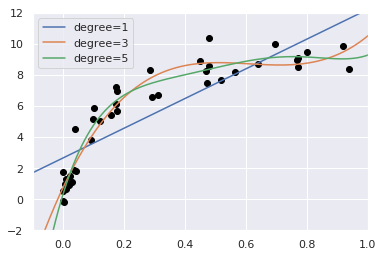

In [7]:
#Visualize data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

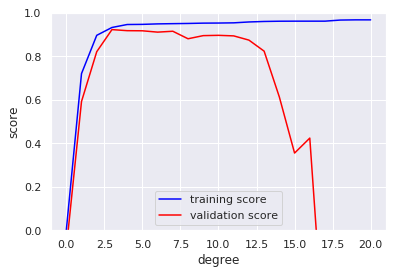

In [8]:
#Plotting Validation Curve vs degree of polynomial
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

From the validation curve, we can see that the optimal trade-off between bias and variance can be found for the 3rd degree polynomial. 

Now, let us plot the 3rd degree polynomial fit. 

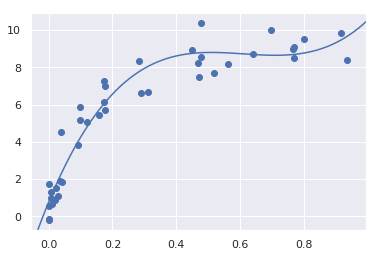

In [9]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

### Learning Curves and Training Data Sizes

The optimal model generally depends on the size of your training data. 

In the example below, we generate a dataset with 5 times more points. 

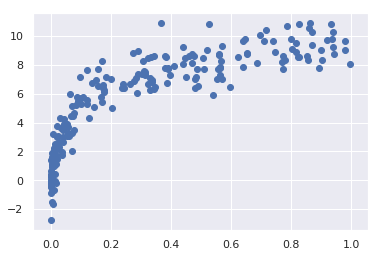

In [10]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

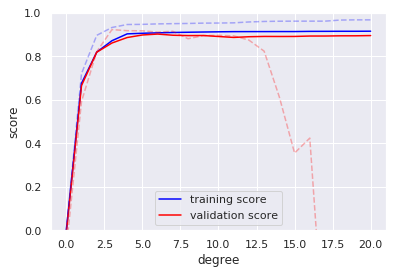

In [11]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

From the curve, we can see that larger datasets can support more complicated models. Even a 20th degree polynomial does not seriously overfit the data. 

#### General Trends
- Models with high complexity will tend to overfit small datasets
- Models with low complexity will tend to underfit large datasets
- The validation scores will always be lower than the training scores

### Comparing Learning curves for low complexity and high complexity models

In this example, we will compute a learning curve for our original dataset with a 2nd degree polynomial and a 9th degree polynomial. 

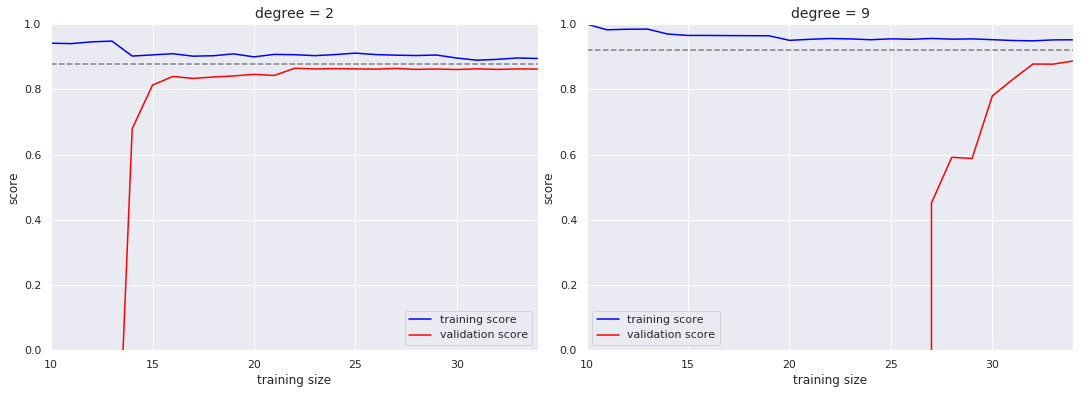

In [13]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

We can see that the more complicated model has a higher model variance (indicated by the difference between the training and validation scores) 

### Grid Search

We can use grid search to automatically find the most optimal polynomial model. 

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [16]:
#Now we will fit the model at each polynomial specified by param_grid, keeping track of scores along the way. 
grid.fit(X, y);

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [18]:
#Now we determine the best parameters
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

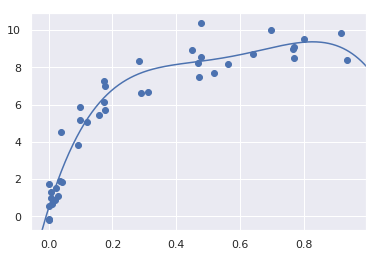

In [20]:
#Visualize the best model
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);